# Week 3 – Multi-view SfM & Refinement
Incremental PnP registration + lightweight refinement producing a refined multi-view point cloud.

In [1]:
from pathlib import Path
import sys

PROJECT_ROOT = Path('.').resolve()
if not (PROJECT_ROOT / 'assets').exists():
    PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

ASSETS_DIR = PROJECT_ROOT / 'assets'
OUTPUT_DIR = PROJECT_ROOT / 'outputs' / 'reconstruction'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Project root:', PROJECT_ROOT)
print('Assets dir:', ASSETS_DIR)
print('Output dir:', OUTPUT_DIR)


Project root: /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project
Assets dir: /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project/assets
Output dir: /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project/outputs/reconstruction


In [2]:
import importlib
from src import feature_matching_pipeline as fmp
from src import two_view_reconstruction as tvr
import src.multi_view_sfm as mvs
importlib.reload(fmp); importlib.reload(tvr); importlib.reload(mvs)
from src.multi_view_sfm import run_incremental_sfm

print('Using files:')
print(' -', fmp.__file__)
print(' -', tvr.__file__)
print(' -', mvs.__file__)


Using files:
 - /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project/src/feature_matching_pipeline.py
 - /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project/src/two_view_reconstruction.py
 - /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project/src/multi_view_sfm.py


## Run incremental SfM (full sequence)
- Detector: SIFT (higher-quality matches)
- Baseline: first two images, then sequential PnP + triangulation
- Refinement: per-view `solvePnPRefineLM` after registering all views


In [3]:
result = run_incremental_sfm(
    asset_dir=ASSETS_DIR,
    detector='SIFT',
    ratio_thresh=0.75,
    output_path=OUTPUT_DIR / 'week3_multi_view_points.ply',
    refine=True,
    min_correspondences=12,
)

print(f'Images processed: {result.stats["images"]}')
print(f'Registered views: {result.stats["registered"]} (skipped: {result.stats["skipped"]})')
print(f'Pose inlier counts: {result.stats["pose_inliers"]}')
print(f'Point cloud size: {len(result.points_3d)}')
print('PLY saved to:', result.ply_path)


Images processed: 14
Registered views: 14 (skipped: [])
Pose inlier counts: {0: 0, 1: 0, 2: 147, 3: 255, 4: 221, 5: 207, 6: 163, 7: 171, 8: 134, 9: 34, 10: 57, 11: 31, 12: 69, 13: 83}
Point cloud size: 2768
PLY saved to: /Users/muhammadabdullahirfan/Desktop/Uni/Sem_5/CV/project/cv-project/outputs/reconstruction/week3_multi_view_points.ply


In [4]:
# View-by-view pose summary
for idx, cam in enumerate(result.poses):
    status = 'OK' if cam.registered else 'SKIPPED'
    name = cam.image_path.name if hasattr(cam, 'image_path') and cam.image_path else f'img_{idx}'
    print(f'[{idx:02d}] {name} -> {status}')
    if cam.registered:
        print('   t:', cam.t.ravel())


[00] img_1.jpeg -> OK
   t: [0. 0. 0.]
[01] img_2.jpeg -> OK
   t: [-1.12233432  0.04457512 -0.22492666]
[02] img_3.jpeg -> OK
   t: [-1.48032763 -0.15143017 -0.6566462 ]
[03] img_4.jpeg -> OK
   t: [-1.30920035 -0.00345847 -1.08825761]
[04] img_5.jpeg -> OK
   t: [-2.19544287  0.05521741 -1.55101642]
[05] img_6.jpeg -> OK
   t: [-2.948959   -0.20934209 -1.7921781 ]
[06] img_7.jpeg -> OK
   t: [-3.02746234 -0.20245839 -2.987332  ]
[07] img_8.jpeg -> OK
   t: [-1.68586193 -0.32502775 -3.77916062]
[08] img_9.jpeg -> OK
   t: [-0.79516235 -0.0830889  -5.27276465]
[09] img_10.jpeg -> OK
   t: [ 1.21695119 -0.20349754 -5.37751282]
[10] img_11.jpeg -> OK
   t: [ 2.58167486 -0.03859212 -5.08454632]
[11] img_12.jpeg -> OK
   t: [ 3.60620345  0.03313895 -4.54394081]
[12] img_13.jpeg -> OK
   t: [ 4.6014044   0.37994049 -3.93525671]
[13] img_14.jpeg -> OK
   t: [ 5.48498201  0.40900835 -3.05807489]


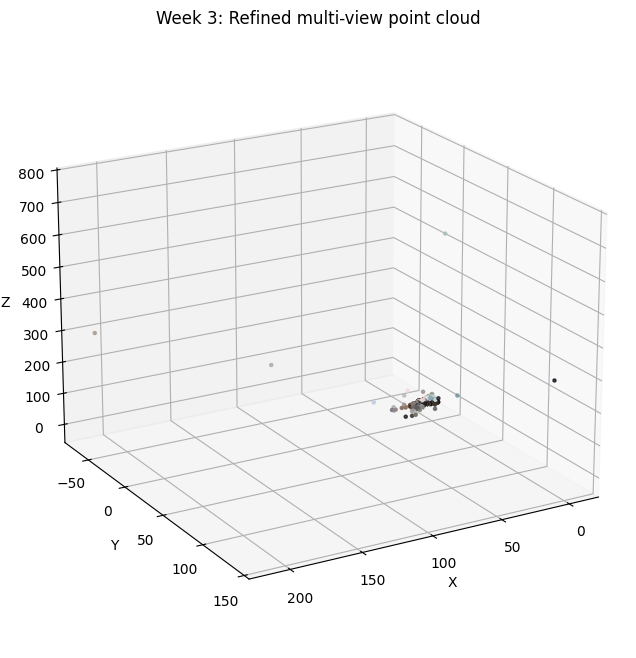

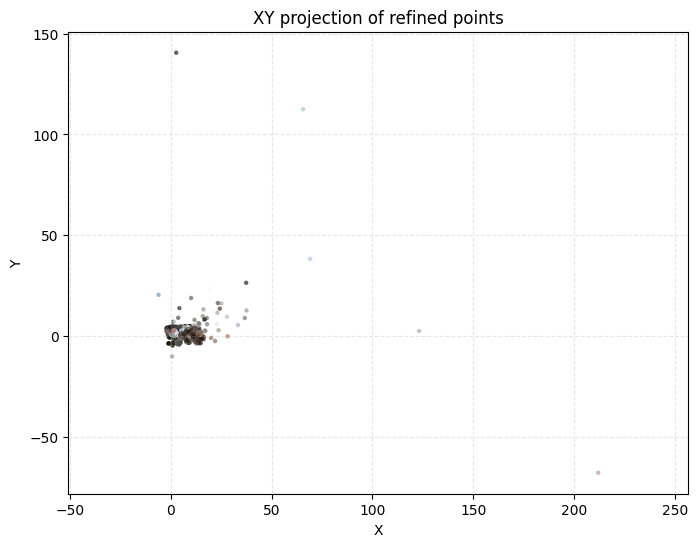

In [5]:
import matplotlib.pyplot as plt
import numpy as np

pts = result.points_3d
colors = result.colors_rgb / 255.0 if result.colors_rgb.size else None

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
kwargs = {'s': 5, 'alpha': 0.7}
if colors is not None:
    kwargs['c'] = colors
ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], **kwargs)
ax.set_title('Week 3: Refined multi-view point cloud')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=20, azim=60)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(pts[:, 0], pts[:, 1], s=5, alpha=0.5, c=kwargs.get('c', 'blue'))
plt.title('XY projection of refined points')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()
